In [5]:
# System Libraries
import os

# Mathematical Libraries
import numpy as np
import numpy.matlib
from scipy.optimize import curve_fit
from scipy import integrate

# Plotting Libraries
import matplotlib.pyplot as plt

# For saving the text as text in the svg file
plt.rcParams['svg.fonttype'] = 'none'

# For saving the text as curves in the svg file
# plt.rcParams['svg.fonttype'] = 'path'

# Set the font of the text in the svg file
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Data management Libraries
import pandas as pd
import pickle

%matplotlib inline

In [6]:
# Spatial Units
cm = 1e-2
mm = 1e-3
um = 1e-6

# Electronic Units
mA = 1e-3
uA = 1e-6
nA = 1e-9

kOhm = 1e3
Ohm = 1

# Optical Units
mW = 1e-3
uW = 1e-6
nW = 1e-9
pW = 1e-12
fW = 1e-15

mCd = 1e-3

Colors used for plots are from the website [David the Math Logic](https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000). We specifically use the IBM palette so that it is color-blind friendly. As we only need five colors at most per plot, this is sufficient. The following colors are included in this palette
1. <span style="color:#648FFF">Blue 1</span> - #648FFF 
2. <span style="color:#785EF0">Blue 2</span> - #785EF0
3. <span style="color:#DC267F">Pink</span> - #DC267F
4. <span style="color:#FE6100">Dark Orange</span> - #FE6100
5. <span style="color:#FFB000">Orange</span> - #FFB000


Below are some fitting functions that are useful for fitting various data array in the course of this notebook

In [192]:
# Fitting function that is used later at one point to fit a polynomial to a data that is used
def fit_polynomial(x_data, y_data, degree):
    """
    Fits a polynomial of a specified degree to the given x and y data.

    Parameters:
    x_data (array-like): The x values of the data points.
    y_data (array-like): The y values of the data points.
    degree (int): The degree of the polynomial to fit.

    Returns:
    numpy.poly1d: A polynomial function representing the fitted polynomial.

    """
    # Fit the polynomial
    coeffs = np.polyfit(x_data, y_data, degree)
    # Generate a polynomial function from the coefficients
    p = np.poly1d(coeffs)
    return p

# Define all the4 fitting functions
def sqrt_fit(x, a, b):
    """
    Calculates the square root fit of the given input.

    Parameters:
    - x: The input value.
    - a: The coefficient for the square root term.
    - b: The constant term.

    Returns:
    The calculated square root fit value.
    """
    return a * np.sqrt(x) + b

def straight_line_fit(x, a, b):
    """
    Calculates the y-values of a straight line given the x-values, slope, and y-intercept.

    Parameters:
    x (array-like): The x-values.
    a (float): The slope of the line.
    b (float): The y-intercept of the line.

    Returns:
    array-like: The y-values of the straight line.

    """
    return a * x + b

def straight_line_zero_fit(x, a):
    """
    Calculates the y-values of a straight line passing through the origin (y = 0) given the x-values and slope.

    Parameters:
    x (float or array-like): The x-values.
    a (float): The slope of the line.

    Returns:
    float or array-like: The y-values of the straight line passing through the origin.
    """
    return a * x

def log_fit(x, a, b, c):
    """
    Calculates the logarithmic fit of the given input data.

    Parameters:
    x (array-like): The input data.
    a (float): The coefficient for the logarithmic term.
    b (float): The constant term added to the input data before taking the logarithm.
    c (float): The constant term added to the result of the logarithmic term.

    Returns:
    array-like: The result of the logarithmic fit.

    """
    return a * np.log(x+b) + c

def log_square_fit(x, a, b, c):
    """
    Calculates the logarithmic square fit of the given input.

    Parameters:
    x (array-like): The input values.
    a (float): Coefficient for the logarithmic square term.
    b (float): Coefficient for the logarithmic term.
    c (float): Constant term.

    Returns:
    array-like: The calculated values of the logarithmic square fit.
    """
    return a * np.square(np.log(x+b)) + c

def log_square_log_fit(x, a, b, c, d):
    """
    Calculates the logarithm of the square of the logarithm of the input value plus constants.

    Parameters:
    x (float): The input value.
    a (float): The coefficient for the square of the logarithm term.
    b (float): The constant added to the input value before taking the logarithm.
    c (float): The coefficient for the logarithm term.
    d (float): The constant added to the input value before taking the logarithm.

    Returns:
    float: The result of the calculation.
    """
    return a * np.square(np.log(x+b)) + c * np.log(x+d)

def exp_fit(x, a, b, c, d):
    """
    Exponential fit function.

    Parameters:
    - x: Input array or scalar.
    - a: Coefficient multiplying the exponential term.
    - b: Exponential term coefficient.
    - c: Exponential term exponent.
    - d: Constant term.

    Returns:
    - The result of the exponential fit function.
    """
    return a * np.exp(b * x + c) + d

def neg_exp_fit(x, a, b, c, d):
    """
    Calculates the negative exponential fit function.

    Parameters:
    - x: The input value.
    - a: The coefficient of the exponential term.
    - b: The coefficient of the linear term.
    - c: The constant term.
    - d: The offset term.

    Returns:
    The calculated value of the negative exponential fit function.
    """
    return a * np.exp(-b * x + c) + d

def fourth_order_fit(x, a, b, c, d, e):
    """
    Calculates the value of a fourth-order polynomial function at a given x value.

    Parameters:
    x (float): The input value for the polynomial function.
    a (float): Coefficient of the x^4 term.
    b (float): Coefficient of the x^3 term.
    c (float): Coefficient of the x^2 term.
    d (float): Coefficient of the x term.
    e (float): Constant term.

    Returns:
    float: The value of the fourth-order polynomial function at the given x value.
    """
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

# Obtaining relevant values for calculation

## LED Board Power Measurements

In [148]:
# Loading the CSV file containing the measured LED current
file_loc_meas = os.path.join(os.getcwd(), 'data', 'Power Response','Measurements', '2024-06-28 Power Measurement.csv')
df_meas = pd.read_csv(file_loc_meas, header=0)

# Visualizing the dataframe
df_meas

,Voltage (V),Voltage R1 (V),Voltage R2 (V),Current (mA)
0,2.55,2.381,0.169,27
1,2.65,2.473,0.177,31
2,2.75,2.524,0.226,38
3,2.85,2.685,0.165,48
4,2.95,2.780,0.170,56
5,3.05,2.852,0.198,63
6,3.15,2.928,0.222,72
7,3.25,3.013,0.237,82
8,3.35,3.081,0.269,92
9,3.45,3.125,0.325,99


In [149]:
resistor_1 = 110.4 #Ohm
resistor_2 = 15.1 #Ohm

# Calculating the current across the two diodes
current_diode_1 = df_meas['Current (mA)'] - ((df_meas['Voltage R1 (V)']/resistor_1) * 1e3)
current_diode_2 = df_meas['Current (mA)'] - ((df_meas['Voltage R2 (V)']/resistor_2) * 1e3)

# Creating new columns in the dataframe and inserting the calculated current values
df_meas['Current Diode 1 (mA)'] = current_diode_1 \

df_meas['Current Diode 2 (mA)'] = current_diode_2 

# Display the dataframe
df_meas

,Voltage (V),Voltage R1 (V),Voltage R2 (V),Current (mA),Current Diode 1 (mA),Current Diode 2 (mA)
0,2.55,2.381,0.169,27,5.432971,15.807947
1,2.65,2.473,0.177,31,8.599638,19.278146
2,2.75,2.524,0.226,38,15.137681,23.033113
3,2.85,2.685,0.165,48,23.679348,37.072848
4,2.95,2.780,0.170,56,30.818841,44.741722
5,3.05,2.852,0.198,63,37.166667,49.887417
6,3.15,2.928,0.222,72,45.478261,57.298013
7,3.25,3.013,0.237,82,54.708333,66.304636
8,3.35,3.081,0.269,92,64.092391,74.185430
9,3.45,3.125,0.325,99,70.693841,77.476821


### Loading the values of the LED VI characteristics and fitting it

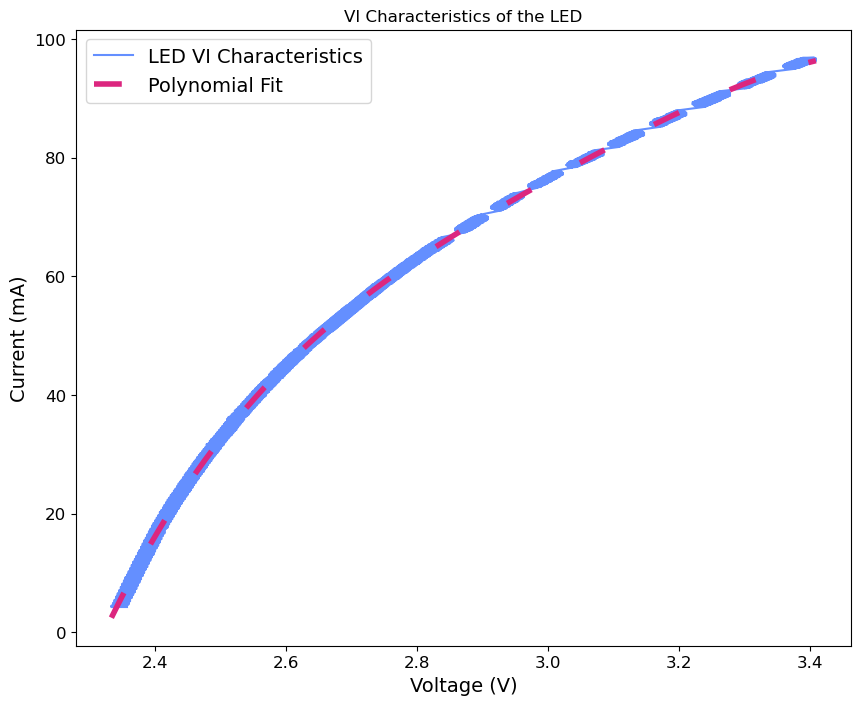

In [150]:
# Loading the csv file containing the VI characteristics of the LED
file_loc_led = os.path.join(os.getcwd(), 'data', 'Power Response','LED Datasheet', 'VLMTG1400 VI.csv') 
df_led = pd.read_csv(file_loc_led, header=0)

# Plotting the VI characteristics of the LED
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_led['Voltage (V)'], df_led['Current (mA)'], label='LED VI Characteristics', c='#648FFF')

# Fitting the VI characteristics of the LED
degree = 4
polynomial_model = fit_polynomial(df_led['Voltage (V)'], df_led['Current (mA)'], degree)

# Predict the luminescence using the polynomial model
current_data = df_led['Voltage (V)']
current_data_fine = np.linspace(min(current_data), max(current_data), 1000)
luminescence_polynomial_fitted = polynomial_model(current_data_fine)

# Plot the fitted polynomial
ax.plot(current_data_fine, luminescence_polynomial_fitted, c='#DC267F', linestyle=(0, (5, 10)), linewidth=4, label='Polynomial Fit')

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Voltage (V)', fontsize=14)
ax.set_ylabel('Current (mA)', fontsize=14)

ax.set_title('VI Characteristics of the LED')
plt.legend(fontsize=14)

### Calculating the current from the LED and creating a new dataframe

In [151]:
voltage_source = df_meas['Voltage (V)'].to_numpy()
led_voltage_drop = 0.88 * voltage_source

# Calculate the current through the LED
led_current = polynomial_model(led_voltage_drop)

# Creating a new dataframe to store the calculated LED current
df_led_current = pd.DataFrame({'Voltage Source (V)': voltage_source, 'LED Voltage Drop (V)': led_voltage_drop, 'LED Current (mA)': led_current})

# Dropping the first value as the emission was not happening at the time and shows erronous fit
df_led_current = df_led_current.drop(0)

# Displaying the dataframe
df_led_current

,Voltage Source (V),LED Voltage Drop (V),LED Current (mA)
1,2.65,2.332,1.982640
2,2.75,2.420,19.691789
3,2.85,2.508,33.563642
4,2.95,2.596,44.527027
5,3.05,2.684,53.369693
6,3.15,2.772,60.738319
7,3.25,2.860,67.138509
8,3.35,2.948,72.934793
9,3.45,3.036,78.350627
10,3.55,3.124,83.468394


## LED Luminescence

### Loading the datasheet values
The datasheet values for the current vs absolute luminescence (mcd) for the LED used (VLMTG1400) were fitted to a square root function. The fit along with the extracted data was plotted in order to obtain a good visual estimate

C:\Users\nkottap\AppData\Local\Temp\ipykernel_38620\585835754.py:78: RuntimeWarning: invalid value encountered in log
  return a * np.log(x+b) + c


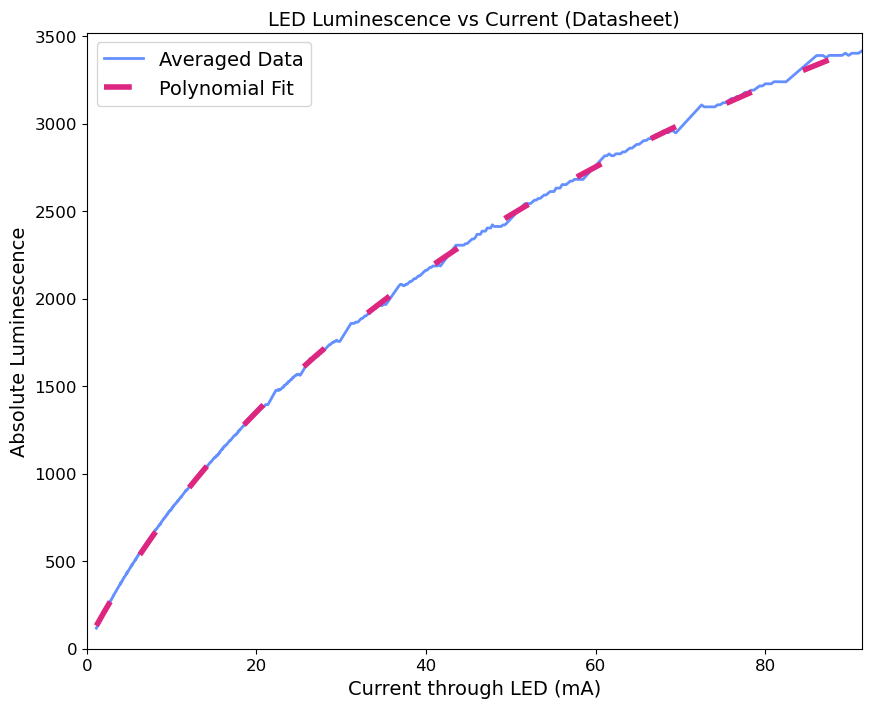

In [152]:
# Loading the CSV file containing the datasheet values of luminescence
file_loc_ds = os.path.join(os.getcwd(), 'data', 'Power Response','LED Datasheet', 'VLMTG1400 Absolute Luminescence.csv')
df_ds = pd.read_csv(file_loc_ds, header=0, index_col=0)

# Convert the stored data in the dataframe to a numpy matrix for ease of processing
ds = np.zeros((len(df_ds), 2))
ds[:,1] = df_ds.to_numpy()[:,0]
ds[:,0] = df_ds.index.values

# Find unique values of the current through the LED
unique_x = np.unique(ds[:, 0])

# Creating a zero array to store the average luminescence for each unique current value. This would account for multiple datapoints per current that were obtained spuriously during extraction
average_y = np.zeros(len(unique_x))

for i, x in enumerate(unique_x):
    indices = np.where(ds[:, 0] == x)
    average_y[i] = np.mean(ds[indices, 1])

# Fitting the fit function for this LED to the
led_lum_fit = log_fit
popt_led_lum, pcov = curve_fit(led_lum_fit, unique_x, average_y)

# Generate a set of x values for the fitted curve
x_fit = np.linspace(min(unique_x), max(unique_x), 1000)

# Evaluate the fitted curve at the x values
luminescence_polynomial_fitted = led_lum_fit(x_fit, *popt_led_lum)


# Plot both the extracted data and the polynomial fitted model for comparison
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(unique_x, average_y, '-', c='#648FFF', linewidth = 2, label='Averaged Data')
ax.plot(x_fit, luminescence_polynomial_fitted, c='#DC267F', linestyle=(0, (5, 10)), linewidth=4, label='Polynomial Fit')

ax.set_xlim([0, max(ds[:, 0])])
ax.set_ylim([0, max(ds[:, 1])])

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Current through LED (mA)', fontsize=14)
ax.set_ylabel('Absolute Luminescence', fontsize=14)

ax.set_title('LED Luminescence vs Current (Datasheet)', fontsize=14) # Title for plots which are not explicitly used in the moment. Comment this line if needed to export the plot

plt.legend(fontsize=14)

### Calculating the LED luminescence in experiments
During the course of the experiment, the LED intensity was varied by controlling the voltage applied to the circuit with an LED and a resistor. However as this would lead to a change in the current across in circuit and subsequently lead to a change in the brightness of the emission from the LE, we only need to consider the current through the LED. In the following cells, the current across the LED is calculated based on the voltage input signal, subsequent absolute luminescence values for a given current are calculated based on the datasheet obtained values in teh previous section

c:\Users\nkottap\.conda\envs\assorted\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


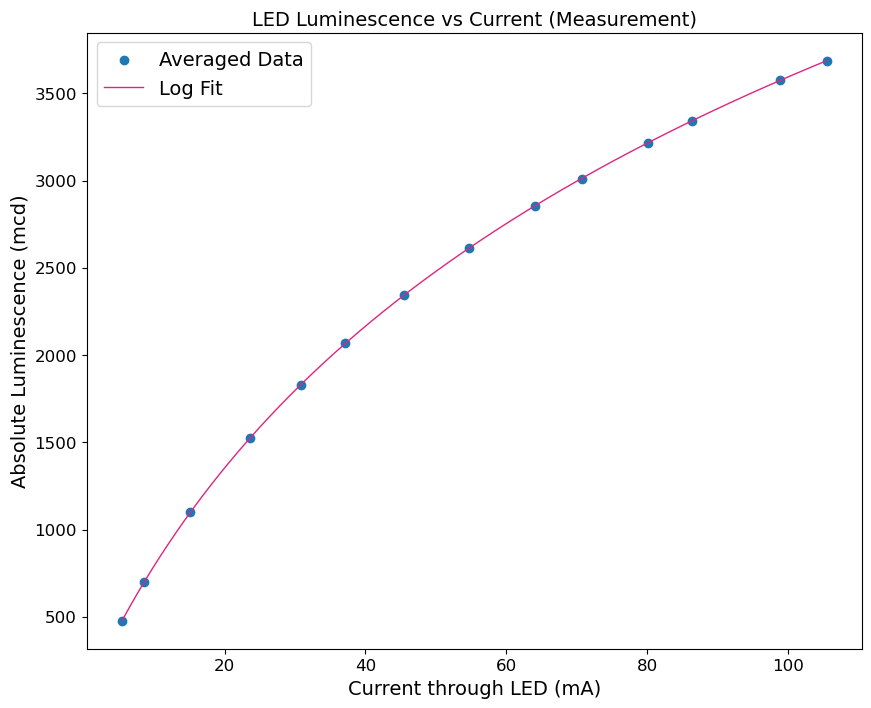

In [153]:
# Calculate the luminescence for the measured values of current
meas_lum = led_lum_fit(df_meas['Current Diode 1 (mA)'].values, *popt_led_lum)

# Fit an exponential curve to the data
current_lum_fit = log_fit

popt, pcov = curve_fit(current_lum_fit, df_meas['Current Diode 1 (mA)'], meas_lum)

# Generate a set of x values for the fitted curve
x_fit = np.linspace(min(df_meas['Current Diode 1 (mA)'].values), max(df_meas['Current Diode 1 (mA)'].values), 1000)

# Evaluate the fitted curve at the x values
y_fit = current_lum_fit(x_fit, *popt)

# Plot the original data and the fitted curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_meas['Current Diode 1 (mA)'].values, meas_lum, label='Averaged Data')
ax.plot(x_fit, y_fit, c='#DC267F', linestyle = 'solid', linewidth = 1, label='Log Fit')

# ax.set_xlim([0, max(ds[:, 0])])
# ax.set_ylim([0, max(ds[:, 1])])

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Current through LED (mA)', fontsize=14)
ax.set_ylabel('Absolute Luminescence (mcd)', fontsize=14)

ax.set_title('LED Luminescence vs Current (Measurement)', fontsize=14) # Title for plots which are not explicitly used in the moment. Comment this line if needed to export the plot

plt.legend(fontsize=14)


## LED Angular response data (Datasheet)
### Loading the file

In [154]:
# File Location
file_loc_angular_x = 'data\Power Response\LED Datasheet\VLMTG1400 Angular Response X.csv'
file_loc_angular_y = 'data\Power Response\LED Datasheet\VLMTG1400 Angular Response Y.csv'

# Load the data
df_angular_x = pd.read_csv(file_loc_angular_x, header=0)
df_angular_y = pd.read_csv(file_loc_angular_y, header=0)

### Calculating the maximum angle at which light is imaged from the lens

In [155]:
lens_diameter = 40 # mm
lens_radius = lens_diameter/2
lens_focal_length = 100 # mm

max_angle_captured = 2 * np.degrees(np.arctan((lens_radius/(2*lens_focal_length))))
print('The maximum solid angle captured by the lens is {:.2f} degrees'.format(max_angle_captured))

The maximum solid angle captured by the lens is 11.42 degrees


### Plotting the angular response of the LED

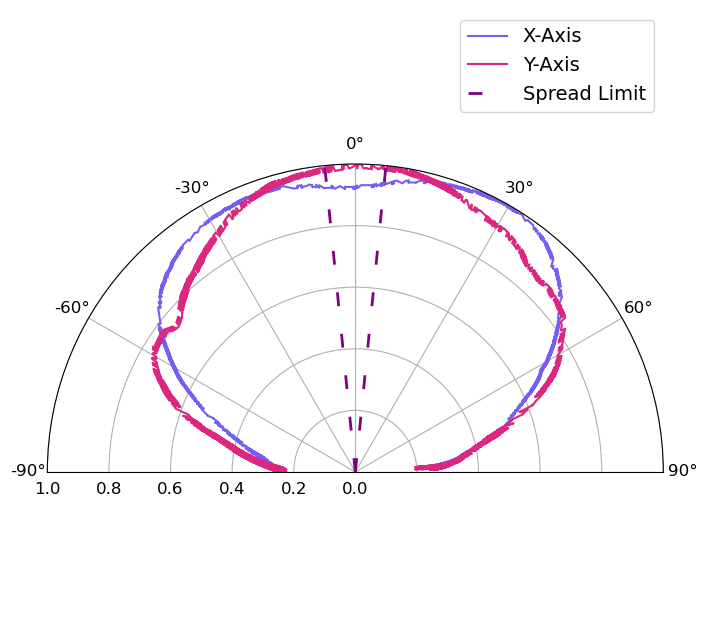

In [156]:
# Modifying the data for plotting the directional properties of the LED
# Shift Angle from 0 to 180 to -90 to 90
df_angular_x['Rot Angle'] = df_angular_x['Angle'] - 90
df_angular_y['Rot Angle'] = df_angular_y['Angle'] - 90

# Plot the data 
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_figheight(8)
fig.set_figwidth(8)

# Plot data and limit the theta direction to show only the range from -90 to 90
ax.plot(np.radians(df_angular_x['Rot Angle']), df_angular_x['Intensity'], label='X-Axis', c='#785EF0')
ax.plot(np.radians(df_angular_y['Rot Angle']), df_angular_y['Intensity'], label='Y-Axis', c='#DC267F')
ax.set_ylim(0, 1)  # Adjust this if necessary based on your data range

# Add vertical lines at 14.03624347 degrees and -14.03624347 degrees
ax.axvline(np.radians(max_angle_captured/2), color='purple', linestyle=(0, (5, 10)), lw=2, label='Spread Limit')
ax.axvline(np.radians(-max_angle_captured/2), color='purple', linestyle=(0, (5, 10)), lw=2)

# Hide the bottom half by setting the theta limits
ax.set_thetamin(-90)
ax.set_thetamax(90)

ax.tick_params(axis='both', which='major', labelsize=12)

# plt.title("Polar Plot of LED Emission Characteristics")
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
plt.legend(fontsize=14)

plt.savefig("out/Power/LED Emission Directionality.pdf", transparent=True)
plt.savefig("out/Power/LED Emission Directionality.png", dpi=800, transparent=True)

### Obtain a fit for the angular response

In [157]:
# Assignining fit parameters
degree_x = 20 # choose the degree of the polynomial (arbitrarily large to capture the trend without overfitting)
degree_y = 20 # choose the degree of the polynomial (arbitrarily large to capture the trend without overfitting)

# Array size to be used for further calculations. THis would also determine the grid size which as a consequence would also determine the resolution of the plot
array_size = 1000

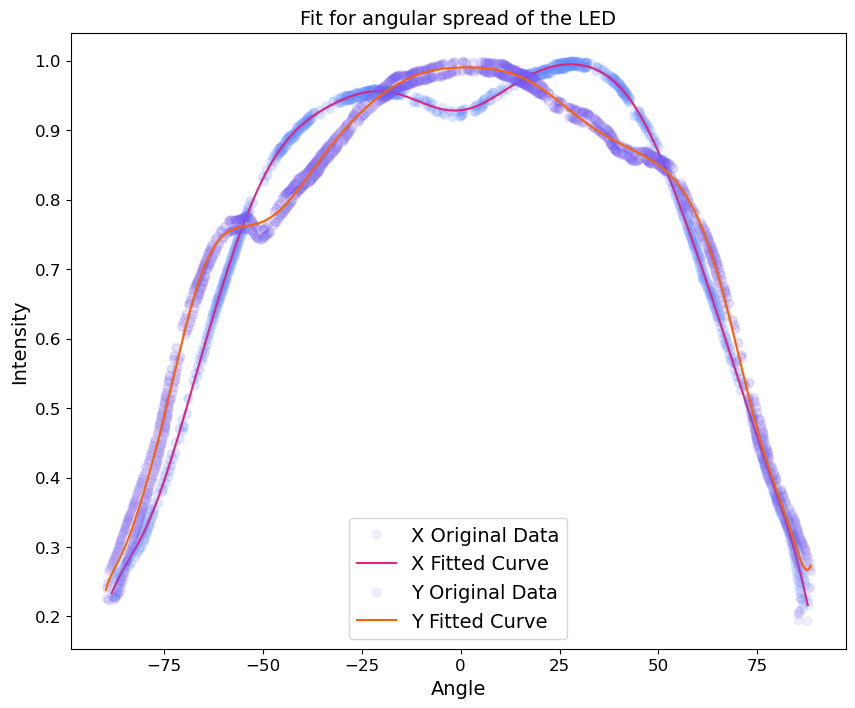

In [158]:
# Fit a polynomial to the data
coeffs_x = np.polyfit(df_angular_x['Rot Angle'], df_angular_x['Intensity'], degree_x)

# Generate x values for the fitted curve
x_fit_x = np.linspace(min(df_angular_x['Rot Angle']), max(df_angular_x['Rot Angle']), 1000)

# Evaluate the fitted curve at the x values
y_fit_x = np.polyval(coeffs_x, x_fit_x)

coeffs_y = np.polyfit(df_angular_y['Rot Angle'], df_angular_y['Intensity'], degree_y)

# Generate x values for the fitted curve
x_fit_y = np.linspace(min(df_angular_y['Rot Angle']), max(df_angular_y['Rot Angle']), 1000)

# Evaluate the fitted curve at the x values
y_fit_y = np.polyval(coeffs_y, x_fit_y)

# Plot the original data and the fitted curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_angular_x['Rot Angle'], df_angular_x['Intensity'], 'o', label='X Original Data', c='#648FFF', alpha=0.1)
ax.plot(x_fit_x, y_fit_x, label='X Fitted Curve', c='#DC267F')
ax.plot(df_angular_y['Rot Angle'], df_angular_y['Intensity'], 'o', label='Y Original Data', c='#785EF0', alpha=0.1)   
ax.plot(x_fit_y, y_fit_y, label='Y Fitted Curve', c='#FE6100')

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Angle', fontsize=14)
ax.set_ylabel('Intensity', fontsize=14)

ax.set_title('Fit for angular spread of the LED', fontsize=14) # Title for plots which are not explicitly used in the moment. Comment this line if needed to export the plot

plt.legend(fontsize=14)


<Figure size 640x480 with 0 Axes>

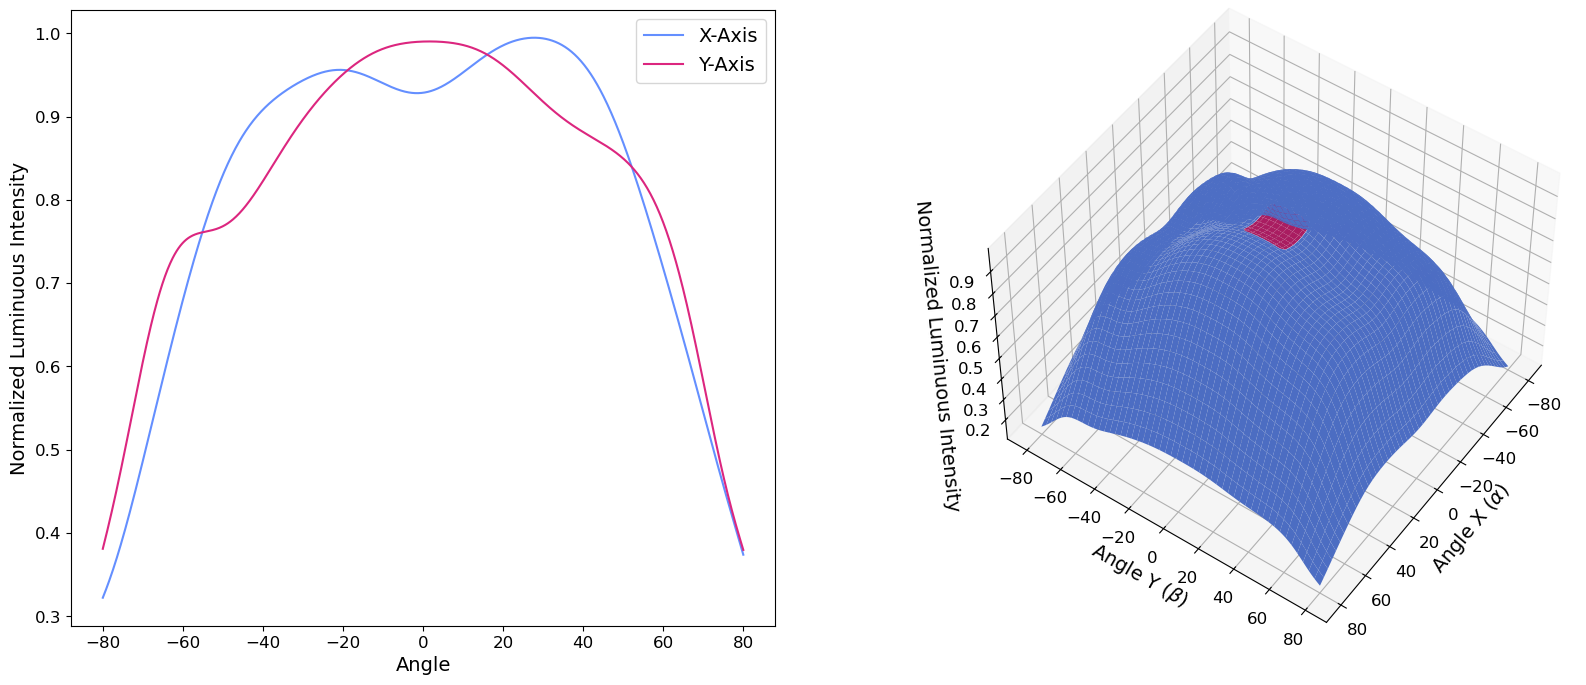

In [159]:
# Generating the desired angles
angle = np.linspace(-80, 80, array_size)  # Restricting the range to -80 to 80 degrees to avoid the edge effects of the fitting
intensity_x = np.polyval(coeffs_x, angle)
intensity_y = np.polyval(coeffs_y, angle)

# Creating a new figure object for the plots
plt.clf()
fig = plt.figure(figsize=(20, 8))

# Plotting the first subplot showing a 2D view
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(angle, intensity_x, label='X-Axis', color='#648FFF')
ax1.plot(angle, intensity_y, label='Y-Axis', color='#DC267F')

# Setting the labels 
ax1.set_xlabel('Angle', fontsize=14)
ax1.set_ylabel('Normalized Luminuous Intensity', fontsize=14)

ax1.tick_params(axis='both', which='major', labelsize=12)

ax1.legend(fontsize=14)

# Extending the 1D data to 2D data
intensity_x_2d = np.matlib.repmat(intensity_x, len(intensity_y), 1)
intensity_y_2d = np.matlib.repmat(intensity_y, len(intensity_x), 1).T

# Calculating the total intensity as a product of the two intensities
intensity_total = intensity_x_2d * intensity_y_2d

# Selecting the angles that are relevant for collection by the lens
angle_x, angle_y = np.meshgrid(angle, angle)

# Calculating the relevant mask for the values that are captured by the lens
mask = (angle_x > -max_angle_captured) & (angle_y > -max_angle_captured) & (angle_x < max_angle_captured) & (angle_y < max_angle_captured)

# Assigning the values outside the mask to NaN to avoid plotting them
modified_intensity_map = np.where(mask, np.nan, intensity_total)

# Calculating a mask that only contains the values that are captured by the lens
selected_intensity_map = np.where(mask, intensity_total, np.nan)

# Plotting the surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Plotting the surface plots
surf = ax2.plot_surface(angle_x, angle_y, modified_intensity_map, color='#648FFF')
surf2 = ax2.plot_surface(angle_x, angle_y, selected_intensity_map, color='#DC267F')

# Changing the viewing angle
ax2.view_init(elev=50., azim=35)

# Setting the labels
ax2.set_xlabel(r'Angle X ($\alpha$)', fontsize=14)
ax2.set_ylabel(r'Angle Y ($\beta$)', fontsize=14)
ax2.set_zlabel('Normalized Luminuous Intensity', fontsize=14)

# Changing the tick size to be convenient
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.show()


In [160]:
# Calculating the percentage of light that is actually captured by the lens
percentage_captured =  np.nansum(selected_intensity_map) / np.nansum(modified_intensity_map)
print(f"The percentage of light captured by the lens is {percentage_captured * 100:.2f}%")

The percentage of light captured by the lens is 2.87%


## Calculating the amount of light that is incident on the lens in Lumens
As **luminous intensity** is defined as

$$I_v = \frac{\Phi_v}{\Omega}$$

Where, $\Phi_v$ is the luminuous flux and $\Omega$ is the solid angle of the incident light. As all the flux produced by the LED is only directed towards a hemisphere surrounding the emitter of the LED. The solid angle corresponding to the hemisphere is $2\pi$. Multiplying this with the luminous intensity gives the total amount of luminous flux

$$\Phi_v = 2 \pi \; I_v $$

<a id='flux_conversion'></a>


<Figure size 640x480 with 0 Axes>

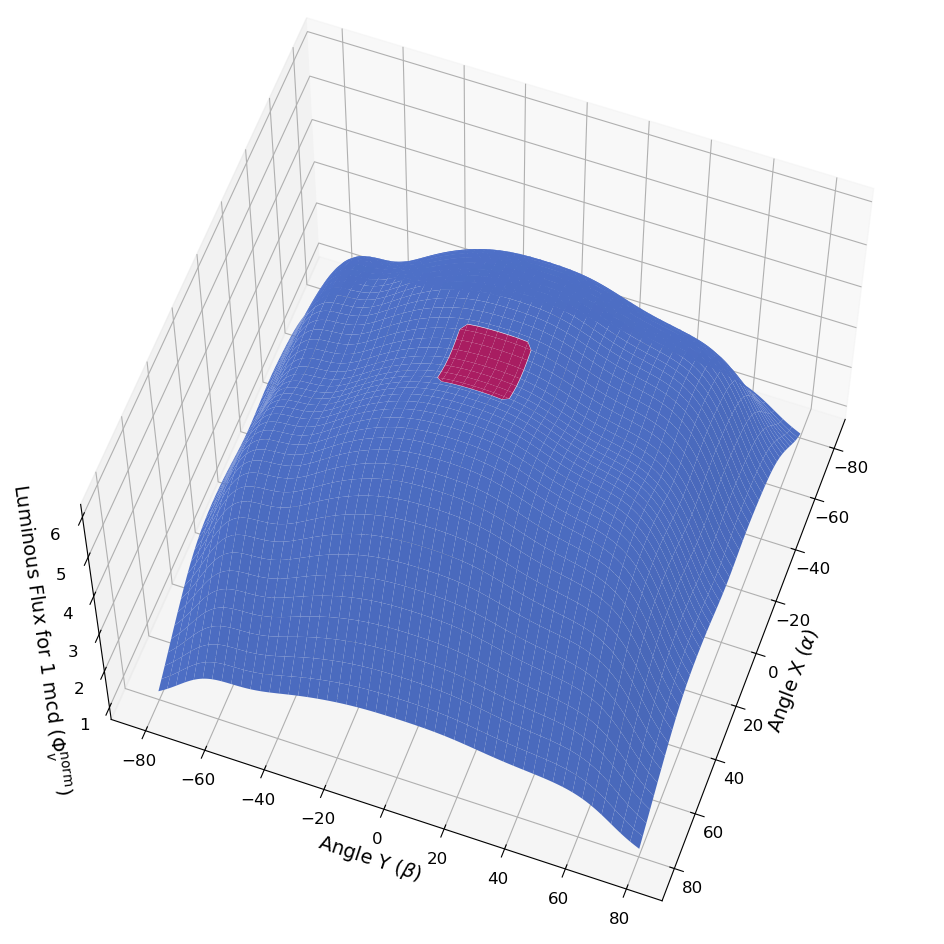

In [161]:
luminous_flux = 2*np.pi*modified_intensity_map
luminous_flux_selected = 2*np.pi*selected_intensity_map

# Display the luminous flux
plt.clf()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface plots
surf = ax.plot_surface(angle_x, angle_y, luminous_flux, color='#648FFF')
surf2 = ax.plot_surface(angle_x, angle_y, luminous_flux_selected, color='#DC267F')

# Changing the viewing angle
ax.view_init(elev=60., azim=20)

# Setting the labels
ax.set_xlabel(r'Angle X ($\alpha$)', fontsize=14)
ax.set_ylabel(r'Angle Y ($\beta$)', fontsize=14)
ax.set_zlabel(r'Luminous Flux for 1 mcd ($\Phi_v^{\text{norm}}$)', fontsize=14)

# Changing the tick size to be convenient
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Converting LED spread to spatial dimension with the lens
We take the angular information for the LED image and then consider how it spatially forms an image on the photodiode detection surface

In [162]:
# Spot size made by the lens
spot_size = [3*mm, 3*mm]

# Calculating equivalent solid angle for the angle calculated
solid_angle = 2 * np.pi * (1 - np.cos(np.radians(max_angle_captured/2)))
print(f"The equivalent solid angle for the lens is {solid_angle:.2f} sr")

# Maximum number of steradians that are possible in the 2-inch lens
max_solid_angle = 2 * np.pi * (1 - np.cos(np.radians(180/2)))
print(f"The maximum solid angle that can be captured by the lens is {max_solid_angle:.2f} sr")

The equivalent solid angle for the lens is 0.03 sr
The maximum solid angle that can be captured by the lens is 6.28 sr


Infromation from [cell on converting luminous intensity to luminous flux](#flux_conversion)

The total flux emenating from the LED for a single mcd of luminous intensity is $2\pi$. We can calculate the distribution of the flux along the selected angles by first assuming that the total flux for all the emission angles is $2\pi$ and then calculating the flux along each of the angles for the LED emission distribution. 

$$
\Phi_{v}^{norm} = \frac{2\pi}{\sum_{\alpha,\beta}I_{v}^{orig}(\alpha, \beta)} \cdot I_{v}^{sel}
$$

<Figure size 640x480 with 0 Axes>

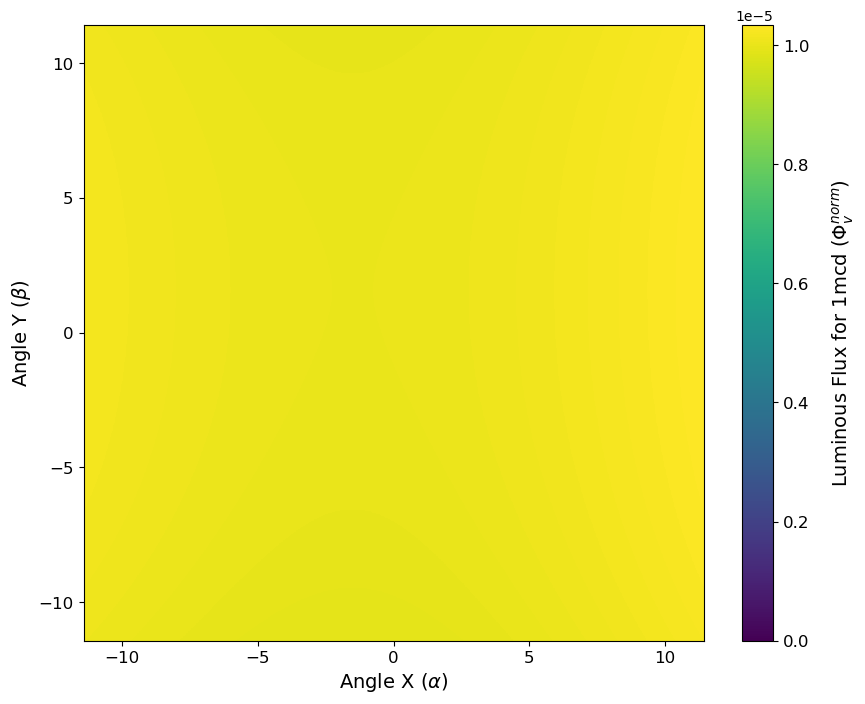

In [163]:
# Generating the desired angles
angle_original = np.linspace(-90,90,1000)
angle_selected = np.linspace(-max_angle_captured, max_angle_captured, array_size)  # Restricting the range to -80 to 80 degrees to avoid the edge effects of the fitting

# Calculating the intensity for the distribution of angles
intensity_x_original = np.polyval(coeffs_x, angle_original)
intensity_y_original = np.polyval(coeffs_y, angle_original)
intensity_x_selected = np.polyval(coeffs_x, angle_selected)
intensity_y_selected = np.polyval(coeffs_y, angle_selected)

# Creating a meshgrid to hold the grid values as well in the same matrix
angle_x_original, angle_y_original = np.meshgrid(angle_original, angle_original)
angle_x_selected, angle_y_selected = np.meshgrid(angle_selected, angle_selected)
spot_x, spot_y = np.meshgrid(np.linspace(-spot_size[0]/2, spot_size[0]/2, array_size), np.linspace(-spot_size[1]/2, spot_size[1]/2, array_size))

# Extending the 1D data to 2D data
intensity_x_2d_original = np.matlib.repmat(intensity_x_original, len(intensity_y_original), 1)
intensity_y_2d_original = np.matlib.repmat(intensity_y_original, len(intensity_x_original), 1).T
intensity_x_2d_selected = np.matlib.repmat(intensity_x_selected, len(intensity_y_selected), 1)
intensity_y_2d_selected = np.matlib.repmat(intensity_y_selected, len(intensity_x_selected), 1).T

# Calculating the total intensity as a product of the two intensities
intensity_total_original = intensity_x_2d_original * intensity_y_2d_original
intensity_total_selected = intensity_x_2d_selected * intensity_y_2d_selected

# converting to relative luminous flux
intensity_total = (2*np.pi/np.nansum(intensity_total_original))*intensity_total_selected

# Creating a new matrix to hold the values
image_on_lens_plane = np.stack((spot_x, spot_y, intensity_total), axis=-1)

# Creating a new figure object for the plots
plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plotting the image on the lens plane
img = ax.pcolormesh(angle_x_selected, angle_y_selected, image_on_lens_plane[...,2], cmap='viridis', vmin=0)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'Angle X ($\alpha$)', fontsize=14)
ax.set_ylabel(r'Angle Y ($\beta$)', fontsize=14)

cbar = plt.colorbar(img)
cbar.set_label(r'Luminous Flux for 1mcd ($\Phi_v^{norm}$)', fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.labelpad = 15

## Account for photodiode angular response on the light incident
### Obtaining the angular respo0nse from the datasheet
The detection form the photodiode has an angular response. When light is incident on the photodiode at a very narrow angle, the light is detected more efficiently than when it is incident at an oblique angle. This information is provided in the datasheet for the photodiode used (SFH2704) 

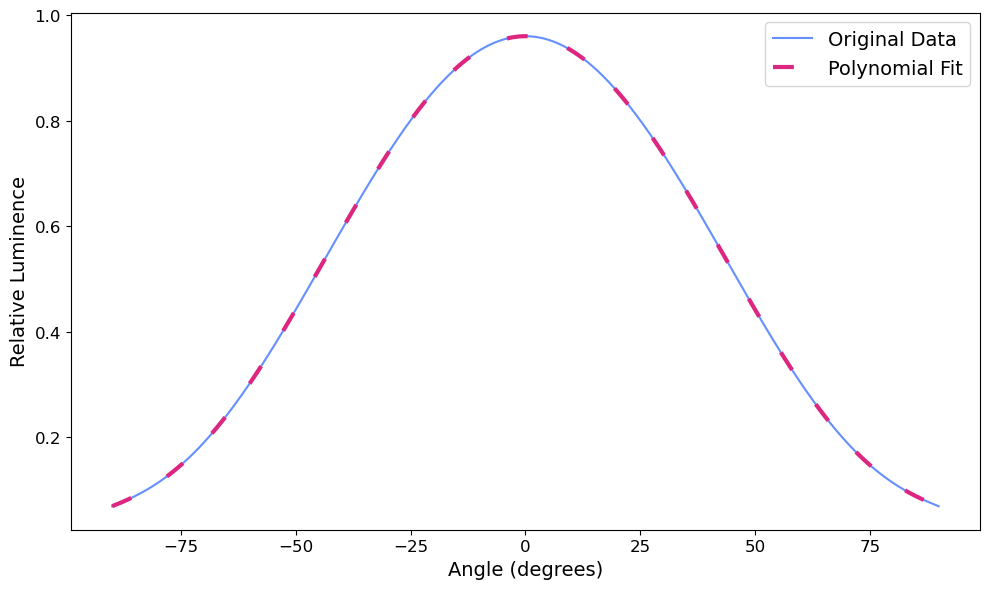

In [164]:
file_loc_pd = 'data\Power Response\PD Datasheet\SFH2704 Directional Fit.csv'

# Reading the CSV file
df_pd = pd.read_csv(file_loc_pd, header=0)
pd_df_headers = df_pd.columns.values

# Performing a polynomial fit
degree_pd = 7
pd_polyfit = fit_polynomial(df_pd[pd_df_headers[0]].to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), degree_pd)

# Plot the fitted polynomial
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(df_pd[pd_df_headers[0]].to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), c='#648FFF', label='Original Data')
ax.plot(df_pd[pd_df_headers[0]].to_numpy(), pd_polyfit(df_pd[pd_df_headers[0]].to_numpy()), c='#DC267F', label='Polynomial Fit', linestyle=(0, (5, 10)), linewidth=3)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Angle (degrees)', fontsize=14)
ax.set_ylabel('Relative Luminence', fontsize=14)

# plt.title('Relative Luminence vs Angle for the Photodiode')
plt.legend(fontsize=14)

plt.tight_layout()

plt.savefig("out/Power/Photodiode Directional Plot.pdf", transparent=True)
plt.savefig("out/Power/Photodiode Directional Plot.png", dpi=800, transparent=True)

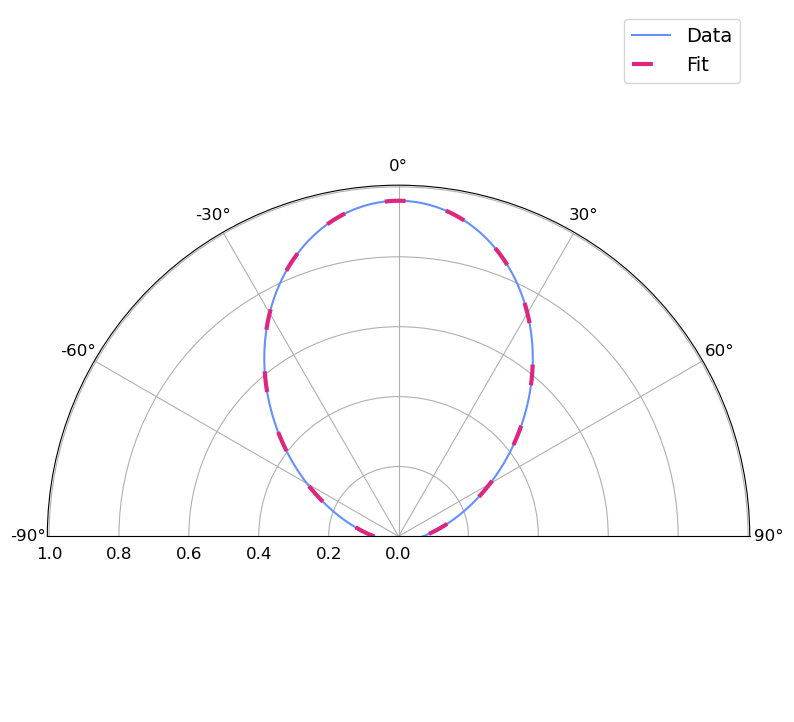

In [165]:
# Plot the data 
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_figheight(8)
fig.set_figwidth(8)

# Plot data and limit the theta direction to show only the range from -90 to 90
ax.plot(np.radians(df_pd[pd_df_headers[0]]).to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), label='Data', c='#648FFF')
ax.plot(np.radians(df_pd[pd_df_headers[0]]).to_numpy(), pd_polyfit(df_pd[pd_df_headers[0]].to_numpy()), label='Fit', c='#DC267F', linestyle=(0, (5, 10)), linewidth=3)

# Hide the bottom half by setting the theta limits
ax.set_thetamin(-90)
ax.set_thetamax(90)

# Changing the axis parameters
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig("out/Power/PD Detection Directionality.pdf", transparent=True)
plt.savefig("out/Power/PD Detection Directionality.png", dpi=800, transparent=True)

### Applying the angular response of the photodiode to the image from the lens
To apply this response, we would just need to consider the section of the emitted beam that is captured by the lens. In the 4f imaging setup used in this experiment, the lens would invert the rays that are incident on the lens. However, as the detection angle of the photodiode is a Gaussian, it is invariant over a rotation axis passing through the center. As we have already assumed that the optical axis of the source, the lens and the photodiode are collinear, a simple product of the gaussian distribution over acceptance angles with the luminous flux $\Phi_v^{norm}$ gives us the angular spread of the light incident on the photodiode

In [166]:
# Generating the distribution over the angles accepted by the lens
accepted_angles = np.linspace(-max_angle_captured, max_angle_captured, array_size)
accepted_angles_x, accepted_angles_y = np.meshgrid(accepted_angles, accepted_angles)

gaussian_spread = pd_polyfit(accepted_angles_x) * pd_polyfit(accepted_angles_y) 

# Taking the product of the detected Gaussian over the luminous flux
angular_detection_distribution = intensity_total * gaussian_spread

# Creating a new data structure
image_on_pd_plane = np.stack((spot_x, spot_y, angular_detection_distribution), axis=-1)

<Figure size 640x480 with 0 Axes>

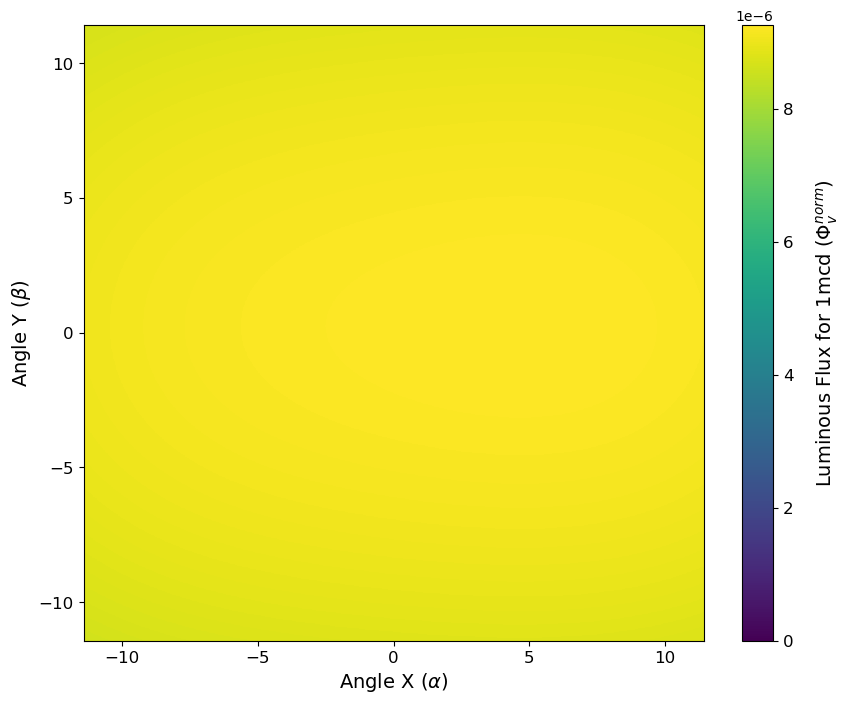

In [167]:
# Creating a new figure object for the plots
plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plotting the image on the lens plane
img = ax.pcolormesh(accepted_angles_x, accepted_angles_y, image_on_pd_plane[...,2], cmap='viridis', vmin=0)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'Angle X ($\alpha$)', fontsize=14)
ax.set_ylabel(r'Angle Y ($\beta$)', fontsize=14)

cbar = plt.colorbar(img)
cbar.set_label(r'Luminous Flux for 1mcd ($\Phi_v^{norm}$)', fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.labelpad = 15


##  Calculating the power loss from optical system
### Applying the lens flip
As mentioned in the earlier section, the lens inverts the object on the image plane. The calculation corresponding to the flip involved in the lens operations are applied in this instance using slicing and in-place operations

In [136]:
# Defining Sizes
detector_size = [1.228*mm, 1.228*mm] # Obtianed from radiant sentivie area value in the datasheet for SFH2704 and assuming a square detector
spot_size = [3*mm, 3*mm]

In [137]:
# Cropping and swapping the axes of the light collected by the LED and that is imaged onto the detector. This follows a thin lens approximation
# Creating the meshgrid of points
spot_x, spot_y = np.meshgrid(np.linspace(-spot_size[0]/2, spot_size[0]/2, array_size), np.linspace(-spot_size[1]/2, spot_size[1]/2, array_size))

# Extracting just the intensity map
only_lens_plane_image = image_on_pd_plane[...,2]

# Creating a new array spot that holds the final information
spot = np.zeros((image_on_lens_plane.shape[0], image_on_lens_plane.shape[1], 3))
spot[...,0] = spot_x
spot[...,1] = spot_y

# Selecting the relevant segments
inter_spot_00 = np.flip(only_lens_plane_image[0:only_lens_plane_image.shape[0]//2, 0:only_lens_plane_image.shape[1]//2])
inter_spot_01 = np.flip(only_lens_plane_image[only_lens_plane_image.shape[0]//2:only_lens_plane_image.shape[0], 0:only_lens_plane_image.shape[1]//2])
inter_spot_10 = np.flip(only_lens_plane_image[0:only_lens_plane_image.shape[0]//2, only_lens_plane_image.shape[1]//2:only_lens_plane_image.shape[1]])
inter_spot_11 = np.flip(only_lens_plane_image[only_lens_plane_image.shape[0]//2:only_lens_plane_image.shape[0], only_lens_plane_image.shape[1]//2:only_lens_plane_image.shape[1]])

# Swappign the indices
spot[0:only_lens_plane_image.shape[0]//2, 0:only_lens_plane_image.shape[1]//2,  2] = inter_spot_11
spot[only_lens_plane_image.shape[0]//2:only_lens_plane_image.shape[0], 0:only_lens_plane_image.shape[1]//2,  2] = inter_spot_10
spot[0:only_lens_plane_image.shape[0]//2, only_lens_plane_image.shape[1]//2:only_lens_plane_image.shape[1],  2] = inter_spot_01
spot[only_lens_plane_image.shape[0]//2:only_lens_plane_image.shape[0], only_lens_plane_image.shape[1]//2:only_lens_plane_image.shape[1],  2] = inter_spot_00

### Calculating the overfill of the detection area
As the detector is smaller than the spot size, we can calculate and apply the transformation for the amount of light that is solely collected by the photodiode

In [138]:
# Extract the x, y positions and the image from the `spot` array
x_positions = spot[..., 0]
y_positions = spot[..., 1]
image = spot[..., 2]

# Create a mask for positions within the detector size
mask = (x_positions > -detector_size[0]/2) & (x_positions < detector_size[0]/2) & \
       (y_positions > -detector_size[1]/2) & (y_positions < detector_size[1]/2)

# Create the `detector_spot` array with zeros
detector_spot = np.zeros_like(spot)

# Copy the valid positions and image to `detector_spot`
detector_spot[..., 0] = x_positions
detector_spot[..., 1] = y_positions
detector_spot[..., 2] = np.where(mask, image, 0)

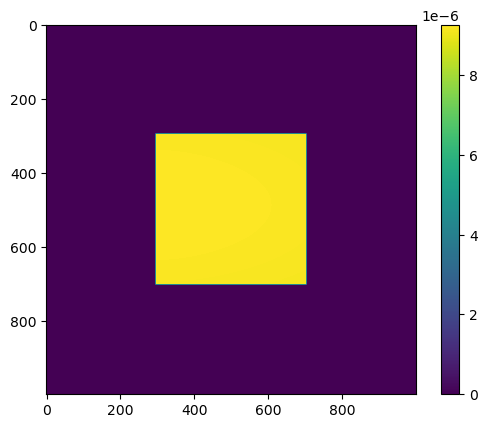

In [139]:
plt.imshow(detector_spot[...,2])
plt.colorbar()

## Summing up the total flux collected using the photodiode
The total flux collected using the photodiode can be summed up and converted to the optical power collected on the photodiode. From this measurement, we can obtain the intensity of light on the photodiode to obtain a relationship between power draw and intensity. This conversion from the photometric to radiometric units by considering the sensitivity and lumnuous efficiency. As the maximum sensitivity ($K_m$) is at 555nm at $683 \text{ lm} \; \text{W}^{-1}$, so $V(533 \text{ nm})$ is 1 

$$(\text{radiometric unit}) = \frac{(\text{photometric unit})}{K_m \cdot V(\lambda)}$$

In [140]:
# Summing over all the colelected light
total_lumens_collected = np.nansum(detector_spot[...,2])
print(f"The total lumens collected by the detector is {total_lumens_collected:.2f} lumens")

# Converting to optical power
Km = 683
V = 1
total_power_collected = total_lumens_collected / (Km * V) # In Watts

print(f"The total power collected is {total_power_collected:.5f} Watts")

The total lumens collected by the detector is 1.53 lumens
The total power collected is 0.00225 Watts


# Power measurements
## Loading the Intermediate board power measurements

C:\Users\nkottap\AppData\Local\Temp\ipykernel_38620\3070936281.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(inter_vals[:,0], fontsize=12)
C:\Users\nkottap\AppData\Local\Temp\ipykernel_38620\3070936281.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(inter_vals[:,1], fontsize=12)


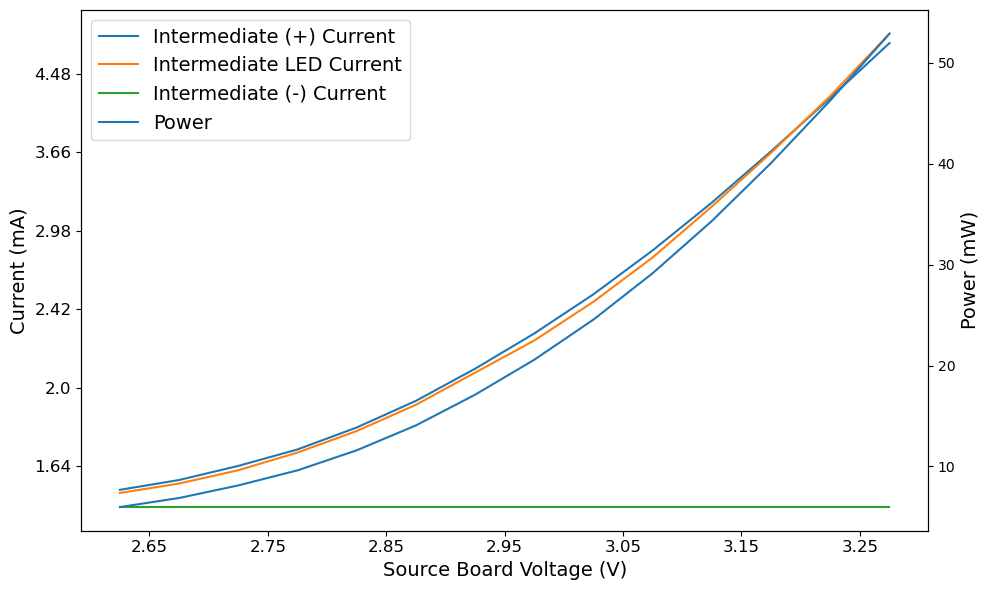

,Source Board Voltage,Source Current,Intermediate (+) Current,Intermediate (-) Current,Intermediate LED Current,Total Power (mW)
0,2.55,0.96,1.39,0.95,1.31,5.9670
1,2.65,0.84,1.64,0.95,1.55,6.8635
2,2.75,0.92,2.00,0.95,1.89,8.1125
3,2.85,0.90,2.42,0.95,2.34,9.6045
4,2.95,1.04,2.98,0.95,2.89,11.5935
5,3.05,0.99,3.66,0.95,3.56,14.0605
6,3.15,1.18,4.48,0.95,4.38,17.1045
7,3.25,1.37,5.38,0.95,5.20,20.5725
8,3.35,1.46,6.38,0.95,6.19,24.5555
9,3.45,1.62,7.50,0.95,7.32,29.1525


In [141]:
# Loading the intermediate file 
file_loc_inter = os.path.join(os.getcwd(), 'data', 'Power Response','Measurements', '2023-10-30 Intermediate Board Measuremetnts.csv')
df_inter = pd.read_csv(file_loc_inter, header=0)

# Converting to numpy array
inter_vals = np.zeros((len(df_inter), 4))
inter_vals[:,0] = df_inter['Source Board Voltage'].to_numpy()
inter_vals[:,1] = df_inter['Intermediate (+) Current'].to_numpy()
inter_vals[:,2] = df_inter['Intermediate (-) Current'].to_numpy()
inter_vals[:,3] = df_inter['Intermediate LED Current'].to_numpy()

# Calculate the power consumed
total_pow = inter_vals[:,0] * (inter_vals[:,1] + inter_vals[:,2])

# Check if the 'Total Power (mW)' column already exists
if 'Total Power (mW)' not in df_inter.columns:
    # Insert the 'Total Power (mW)' column into the dataframe
    df_inter.insert(5, 'Total Power (mW)', total_pow, True)

# Plotting the Voltage v/s current curve

fig,ax1 = plt.subplots(figsize=(10, 6))
line1, = ax1.plot(inter_vals[:,0], inter_vals[:,1], label='Intermediate (+) Current')
line2, = ax1.plot(inter_vals[:,0], inter_vals[:,3], label='Intermediate LED Current')
line3, = ax1.plot(inter_vals[:,0], inter_vals[:,2], label='Intermediate (-) Current')

ax1.set_xticklabels(inter_vals[:,0], fontsize=12)
ax1.set_yticklabels(inter_vals[:,1], fontsize=12)

ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlabel('Source Board Voltage (V)', fontsize=14)
ax1.set_ylabel('Current (mA)', fontsize=14)

ax2 = ax1.twinx()
line4, = ax2.plot(inter_vals[:,0], total_pow, label='Power')

# ax2.set_yticklabels(total_pow, fontsize=12)
ax2.set_ylabel('Power (mW)', fontsize=14)

# Combine legends from both axes
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig("out/Power/Intermediate Board Power Consumption.pdf", transparent=True)
plt.savefig("out/Power/Intermediate Board Power Consumption.png", dpi=800, transparent=True)
plt.show()

df_inter

### Exporting the measured data as a markdown table

In [168]:
# from  df_inter, drop columns 'Source Board Voltage' and 'Source Current' and save the rest of the dataframe along with the headings to a csv file named '2024-01-04 Selected Data.csv'
df_selected = df_inter.drop(['Source Board Voltage', ], axis=1)
df_selected = df_selected.round(2)
df_selected = df_selected.astype(float).apply(lambda x: round(x, 2))
df_selected.to_csv('out/Power/2024-01-04 Selected Data.csv', index=False)
 
latex_table = df_selected.to_latex(index=False, float_format='%.2f')
markdown_table = df_selected.to_markdown(index=False, floatfmt=".2f")
print(markdown_table)


|   Source Current |   Intermediate (+) Current |   Intermediate (-) Current |   Intermediate LED Current |   Total Power (mW) |
|-----------------:|---------------------------:|---------------------------:|---------------------------:|-------------------:|
|             0.96 |                       1.39 |                       0.95 |                       1.31 |               5.97 |
|             0.84 |                       1.64 |                       0.95 |                       1.55 |               6.86 |
|             0.92 |                       2.00 |                       0.95 |                       1.89 |               8.11 |
|             0.90 |                       2.42 |                       0.95 |                       2.34 |               9.60 |
|             1.04 |                       2.98 |                       0.95 |                       2.89 |              11.59 |
|             0.99 |                       3.66 |                       0.95 |                   

## Calculate the power draw for different photocurrents

### Calculating the light collected for different input input currents
We know the relation between input current and the amount of light that is emitted from the LED. From the transformation we calculated earlier for the amount of light collected from a photodiode for a unit mcd luminous intensty, we can obtain the true value of the power that is incident on the photodiode surface 

In [169]:
# Obtaining the radiant sensitive area from the datasheet (in mm2)
radiant_sensitive_area = 1.51
radiant_sensitive_area_cm2 = radiant_sensitive_area/100

# Calculating the total optical power (mW) - The units of the array meas_lum is in mCd
total_optical_power = meas_lum * total_power_collected 

# Calculating the intensity
intensity_on_pd = total_optical_power / radiant_sensitive_area_cm2

# Photocurrent generated from the photodiode. This is calculated from the value of the total_optical_power
responsivity = 0.34 # A/W This value is obtained from the datasheet of SFH2704 
photocurrent = responsivity * total_optical_power # In mA

# Create a new dataframe to hold the data
df_optical_power = pd.DataFrame({'current (mA)': df_meas['Current Diode 1 (mA)'], 'luminous intensity (mCd)': meas_lum, 'power (mW)': total_optical_power, 'intensity (mW/cm2)': intensity_on_pd, 'photocurrent (mA)': photocurrent})

In [170]:
df_meas['Current Diode 1 (mA)'].to_numpy().shape

(14,)

In [171]:
# DIsplaying the obtained dataframe
df_optical_power

,current (mA),luminous intensity (mCd),power (mW),intensity (mW/cm2),photocurrent (mA)
0,5.432971,477.084678,1.071666,70.971270,0.364366
1,8.599638,700.159655,1.572755,104.155975,0.534737
2,15.137681,1098.310186,2.467113,163.384975,0.838818
3,23.679348,1527.254627,3.430643,227.194888,1.166419
4,30.818841,1829.881223,4.110427,272.213717,1.397545
5,37.166667,2067.235312,4.643591,307.522588,1.578821
6,45.478261,2342.970305,5.262969,348.541014,1.789410
7,54.708333,2612.662561,5.868774,388.660520,1.995383
8,64.092391,2856.009161,6.415399,424.860838,2.181236
9,70.693841,3012.044389,6.765898,448.072689,2.300405


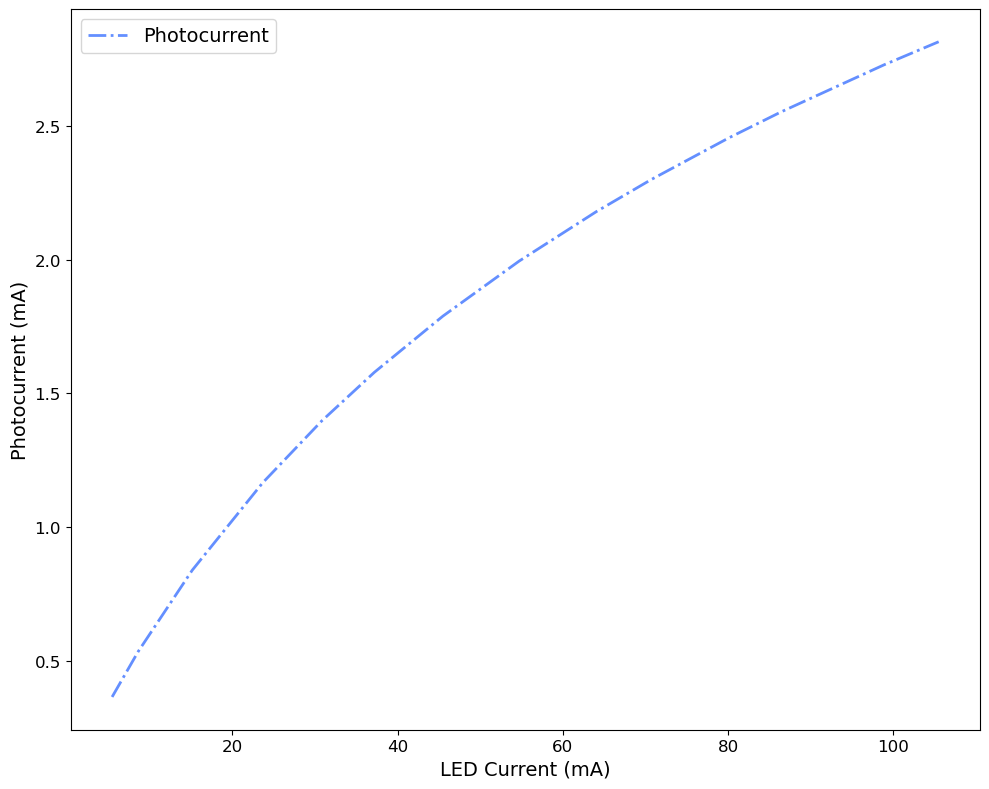

In [172]:
# Plotting the variation of output photocurrent with input LED current
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_optical_power['current (mA)'], df_optical_power['photocurrent (mA)'], label='Photocurrent', linestyle = '-.', c='#648FFF', linewidth=2) 

ax.set_xlabel('LED Current (mA)', fontsize=14)
ax.set_ylabel('Photocurrent (mA)', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig("out/Power/Photocurrent vs LED Current.pdf", transparent=True)
plt.savefig("out/Power/Photocurrent vs LED Current.png", dpi=800, transparent=True)

In [173]:
# Create a new temporary dataframe to hold the data for comparing power consumption with intensity and photocurrent
df_final_power = pd.DataFrame({'intensity (mW/cm2)': df_optical_power['intensity (mW/cm2)'], 'photocurrent (mA)': df_optical_power['photocurrent (mA)'], 'Total Power (mW)': df_inter['Total Power (mW)']})

df_final_power.drop([])
df_final_power

,intensity (mW/cm2),photocurrent (mA),Total Power (mW)
0,70.971270,0.364366,5.9670
1,104.155975,0.534737,6.8635
2,163.384975,0.838818,8.1125
3,227.194888,1.166419,9.6045
4,272.213717,1.397545,11.5935
5,307.522588,1.578821,14.0605
6,348.541014,1.789410,17.1045
7,388.660520,1.995383,20.5725
8,424.860838,2.181236,24.5555
9,448.072689,2.300405,29.1525


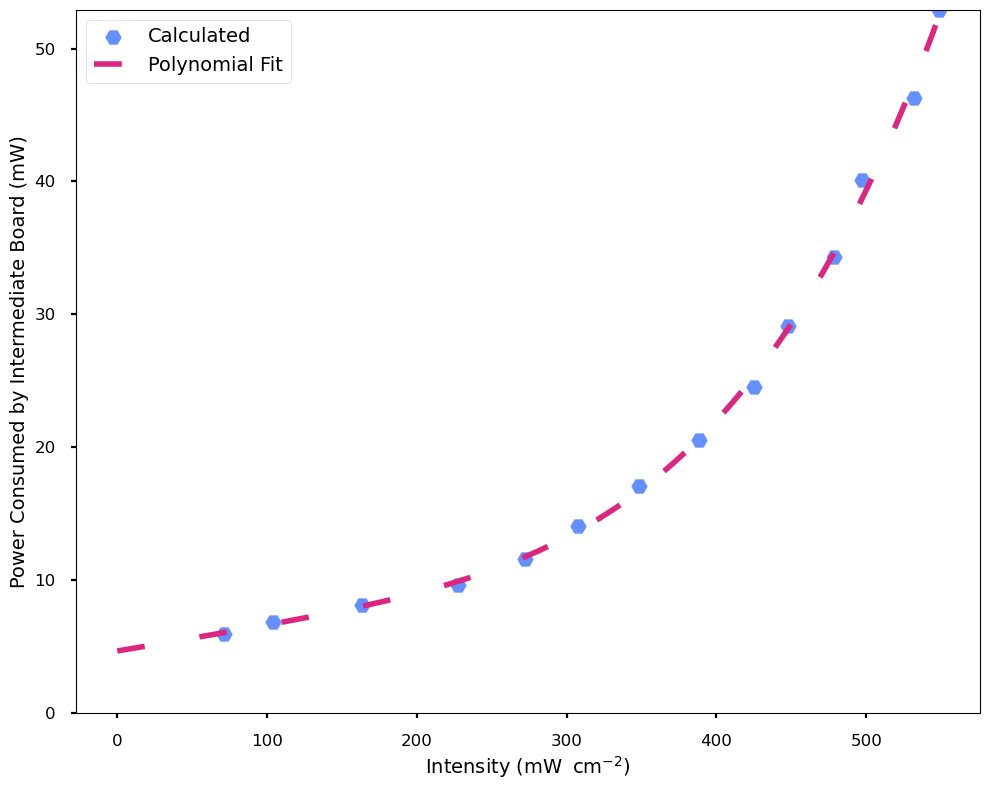

In [209]:
# Fitting the photocurrent vs power consumed data
power_intensity_fit_fn = fourth_order_fit

# Create a new temporary dataframe to hold the data for comparing power consumption with intensity and photocurrent
df_final_power = pd.DataFrame({'intensity (mW/cm2)': df_optical_power['intensity (mW/cm2)'], 'photocurrent (mA)': df_optical_power['photocurrent (mA)'], 'Total Power (mW)': df_inter['Total Power (mW)']})

# Dropping the anomolous values just for the fitting
# df_final_power = df_final_power.drop([0,2,4])

x_inter_pc_pow_fit = np.linspace(0, max(df_final_power['intensity (mW/cm2)']), 1000)
pc_pow_params, _ = curve_fit(power_intensity_fit_fn, df_final_power['intensity (mW/cm2)'], df_final_power['Total Power (mW)'])
inter_pc_pow_fit = power_intensity_fit_fn(x_inter_pc_pow_fit, *pc_pow_params)

# Plotting power consumed by the intermediate board vs photocurrent generated
fig, ax = plt.subplots(figsize=(10, 8))
power_arr = df_inter['Total Power (mW)'].to_numpy()
ax.scatter(df_final_power['intensity (mW/cm2)'], df_final_power['Total Power (mW)'], label='Calculated', c='#648FFF', marker='H')
ax.plot(x_inter_pc_pow_fit, inter_pc_pow_fit, label='Polynomial Fit', c='#DC267F', linestyle=(0, (5, 10)), linewidth=4)

ax.set_xlabel(r'Intensity ($\text{mW}\;\;\text{cm}^{-2}$)', fontsize=14)
ax.set_ylabel('Power Consumed by Intermediate Board (mW)', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([0, max(df_final_power['Total Power (mW)'])])

plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig("out/Power/Intensity vs Power Consumed.pdf", transparent=True)
plt.savefig("out/Power/Intensity vs Power Consumed.png", dpi=800, transparent=True)

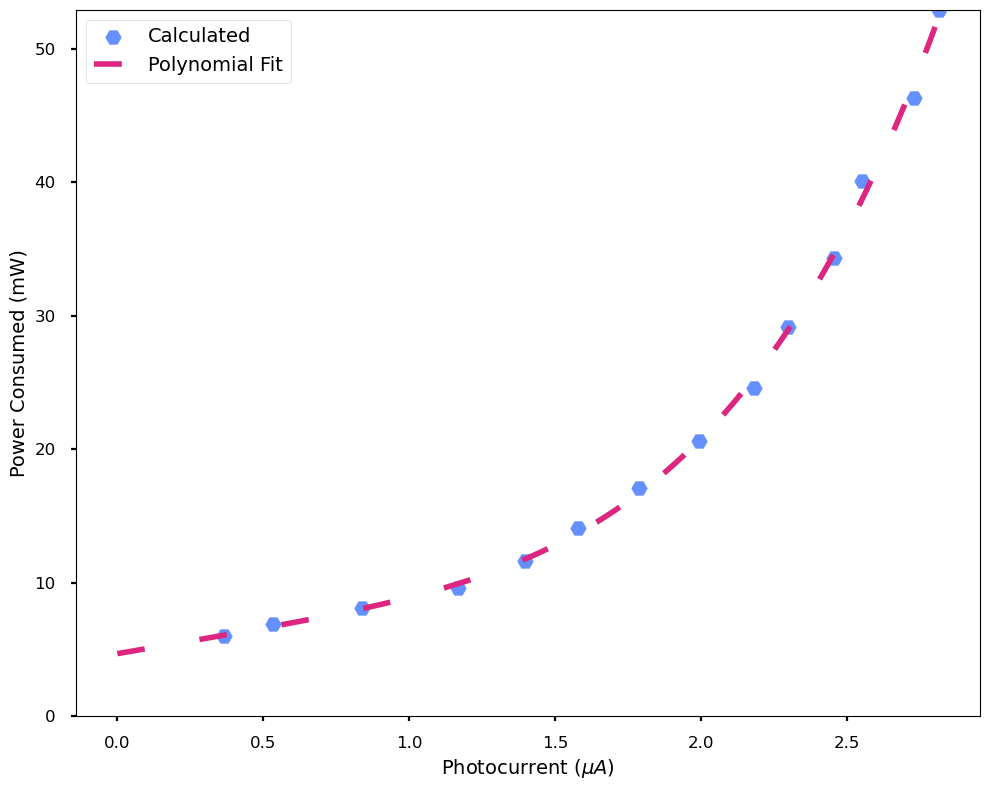

In [210]:
power_photocurrent_fit_fn = fourth_order_fit

# Fit this plot with a polynomial
pc_pow_params, _ = curve_fit(power_photocurrent_fit_fn, df_final_power['photocurrent (mA)'], df_final_power['Total Power (mW)'])
x_inter_pc_pow_fit = np.linspace(0, max(df_final_power['photocurrent (mA)']), 1000)
inter_pc_pow_fit = power_photocurrent_fit_fn(x_inter_pc_pow_fit, *pc_pow_params)

# Plot of power consumed vs photocurrent
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_final_power['photocurrent (mA)'], df_final_power['Total Power (mW)'], label='Calculated', c='#648FFF', marker='H')
ax.plot(x_inter_pc_pow_fit, inter_pc_pow_fit, label='Polynomial Fit', c='#DC267F', linestyle=(0, (5, 10)), linewidth=4)

ax.set_xlabel(r'Photocurrent $(\mu A)$', fontsize=14)
ax.set_ylabel('Power Consumed (mW)', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([0, max(df_final_power['Total Power (mW)'])])

plt.legend(fontsize=14)

plt.tight_layout()

plt.savefig("out/Power/Photocurrent vs Power Consumed.pdf", transparent=True)
plt.savefig("out/Power/Photocurrent vs Power Consumed.png", dpi=800, transparent=True)


In [257]:
# Selecting the photocurrent value under consideration to be 0.8 microAmps
# This number is just an educated guess based on the amplification and matching the detected light leqvel so that light decay through the system is non-existent
# Might be suspect as with the amplification and the desired photocurrent, we get 2nA. Setting this value instead of 0.8 uA
# pc_val = 0.8
pc_val = 0.002

# Number of channels on the board
num_channels = 32

# Find the power consumed at this value
power_consumed = power_photocurrent_fit_fn(pc_val, *pc_pow_params) * 10**-3

# Decided to use experimental and design values instead
power_consumed = (0.8 * 10**-3) * 3.5

# Print the total power consumed
print(f"The total power consumed by the intermediate board at a photocurrent of {pc_val} mA is {power_consumed} mW")

The total power consumed by the intermediate board at a photocurrent of 0.002 mA is 0.0028 mW


# Electronic Transfer Function

## Optical Losses
This calculated the optical losses in the real experiment with the photomasks and the LEDs at a certain distance

In [214]:
# Calculating the losses
# Conversion efficiency from electrical signal of the LED to the optical signal from the LED
led_electronic_conversion_efficiency = 0.15

# SLM losses
slm_losses = 0.5

# Total amount of light blocked due to weight matrices
weight_matrix_values = 0.1

# Loss due to differencing operations
differencing_operation_values = 0.2

# Losses due to the offset of the array from the idealized center
array_center_offset_losses_2d = 0.5

# Losses due to the photodiode fill factor
pd_fill_factor = 0.125

# Losses due to diffraction at the edges of the array
diffraction_edge_losses = 0.5

# Loss due to the selection of a narrow angular response from the photodiode
pd_angle_losses = 0.7

# Calculating the total losses
total_losses = led_electronic_conversion_efficiency * slm_losses * weight_matrix_values * differencing_operation_values * array_center_offset_losses_2d * pd_fill_factor * diffraction_edge_losses * pd_angle_losses

print(1/(total_losses))

30476.190476190477


## Relationship between bandwidth and minimum optical power
Calculating the relationship between the minimum optical power needed to run the system vs the system bandwidth. The following equations are used in this calculations
The total bandwidth of the system can be calculated as 
$$\textrm{Total Bandwidth} = \Bigg(\frac{1}{f_{c_1}^2} + \frac{1}{f_{c_2}^2} \Bigg)^{-\frac{1}{2}} $$
As the first stage is a non-inverting amplifier, the first stage's bandwidth can be calculated as follows
$$f_{-3dB} = \sqrt{\frac{\textrm{GBW}}{2\pi R_f C_{tot}}} \textrm{Hz}$$
The minimum optical power needed can then be calculated from the minimum power as 
$$P_{min} = \textrm{NEP} \cdot \sqrt{f_{-3dB}^{sys}} \cdot \textrm{SNR}$$

This last equation can be used to find the optimum bandwidth in lieu of the noise response of the system

In [215]:
# Defining as a small function to ease calculation
def tia_bandwidth(GBW, Rf, C_tot):
    return np.sqrt(GBW / (2 * np.pi * Rf * C_tot))

def vf_bandwidth(GBW):
    return GBW

def min_power_calc(bandwidth, noise_equivalent_power, snr):
    return noise_equivalent_power * np.sqrt(bandwidth) * snr

def total_bandwidth_calc(bandwidth_1, bandwidth_2):
    return 1/np.sqrt((1/bandwidth_1**2) + (1/bandwidth_2**2))


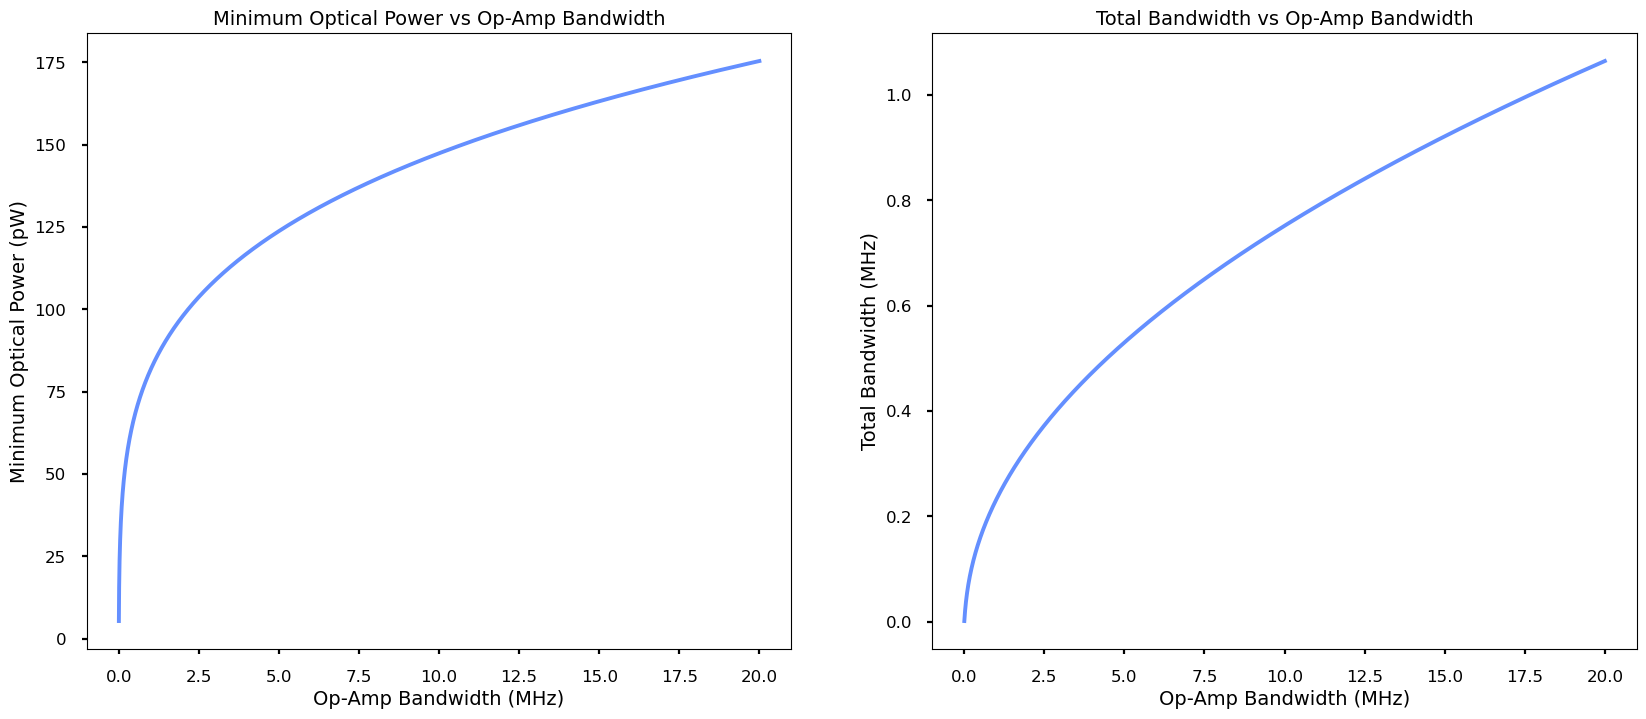

In [294]:
# Possible bandwidth ranges on the op-amps that we could choose
oa_bandwidth_range = np.linspace(1e3, 20e6, 10000)

# Fixing the feedback resistance value (to maintain the gain) and for the same PCB design and photodiode capacitance (8pF at -4V bias)
Rf = 350 * 1e3
Rl = 10
Cf = 8 * 1e-12

# Parameters from the photodiode
noise_equivalent_power = 0.017 * 1e-12
snr = 10

# Calculating the minimum optical power
min_power = min_power_calc(total_bandwidth_calc(tia_bandwidth(oa_bandwidth_range, Rf, Cf), vf_bandwidth(oa_bandwidth_range)), noise_equivalent_power, snr)

# Plotting the minimum optical power vs the op-amp bandwidth
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
ax1 = axs[0]
ax1.plot(oa_bandwidth_range/1e6, min_power/1e-12, color='#648FFF')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel('Op-Amp Bandwidth (MHz)', fontsize=14)
ax1.set_ylabel('Minimum Optical Power (pW)', size=14)
ax1.set_title('Minimum Optical Power vs Op-Amp Bandwidth', size=14)

ax2 = axs[1]
ax2.plot(oa_bandwidth_range/1e6, total_bandwidth_calc(tia_bandwidth(oa_bandwidth_range, Rf, Cf), vf_bandwidth(oa_bandwidth_range))/1e6, color='#648FFF')
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel('Op-Amp Bandwidth (MHz)', fontsize=14)
ax2.set_ylabel('Total Bandwidth (MHz)', fontsize=14)
ax2.set_title('Total Bandwidth vs Op-Amp Bandwidth', fontsize = 14)


# Save the figure
plt.savefig("out/Power/Op-Amp Bandwidth Plots.pdf", transparent=True)
plt.savefig("out/Power/Op-Amp Bandwidth Plots.png", dpi=800, transparent=True)

# Show the plot
plt.show()


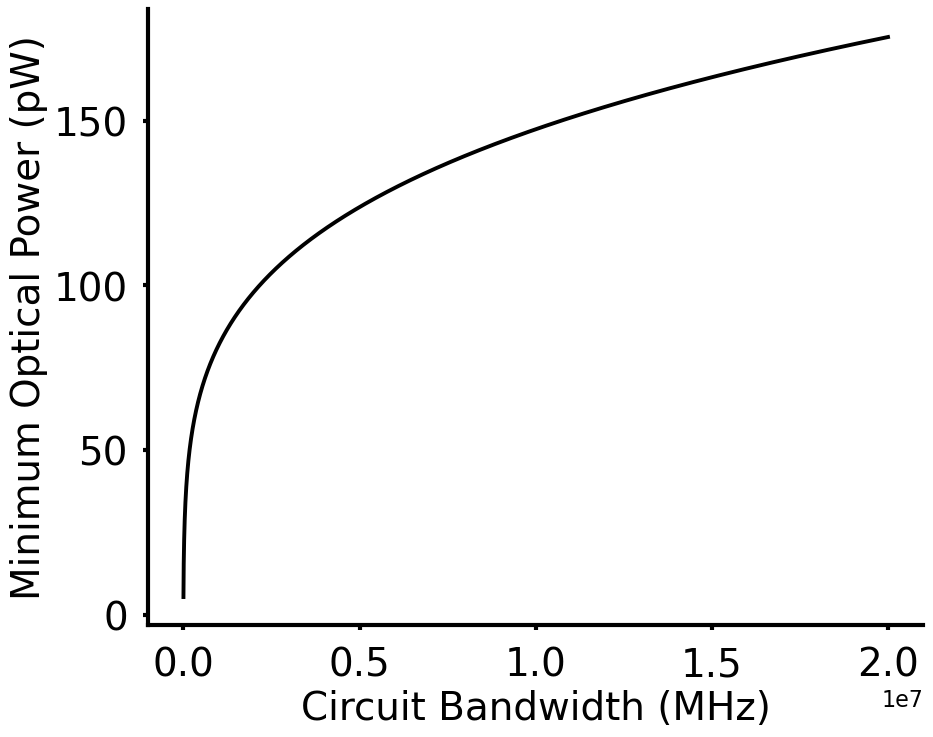

In [240]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(oa_bandwidth_range, min_power/1e-12, '-', color='k')
ax.set_xlabel('Circuit Bandwidth (MHz)', fontsize=28)
ax.set_ylabel('Minimum Optical Power (pW)', fontsize=28)

ax.tick_params(axis='both', labelsize=28, width=3)

# Increase the line thickness of the bounding box
for spine in ax.spines.values():
    spine.set_linewidth(3)

# Remove splines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# Add splines on left and bottom sides
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('out/Power/Minimum Power.svg', bbox_inches='tight')
plt.show()


## Power consumption
Calculating the power consumption of the board assuming an 80% efficiency of the amplifier circuit and an op-amp with a bandwidth of 90MHz 

In [262]:
# Choosing the bandwidth of the op-amp to be 10MHz for comparison with the simulation
total_bandwidth_sel = total_bandwidth_calc(tia_bandwidth(10e6, Rf, Cf), vf_bandwidth(40e6))
min_power_sel = min_power_calc(total_bandwidth_sel, noise_equivalent_power, snr)

# Calculating the maximum photocurrent
sensitivity_pd = 0.34 # A/W
photocurrent = sensitivity_pd * min_power_sel

# Current through LED
gain_ckt = Rf/Rl
led_current = photocurrent * gain_ckt
led_light = led_lum_fit(led_current, *popt_led_lum)

led_light

30.36842797016925

# Calculating the number of operations performed by the board
An operation in this instance can be defined a multiplicative operation perfromed by the scheme. The modulation of light emitted from a single LED modulated by a single mini-block can be treated as a product. For an emitter board the size of $m_e \times n_e$ and the detector board of size $m_d \times n_d$, for a single element on the emitter board, the total number of operations that happen are $m_d \times m_e \times n_d \times n_e$. 

For the boards used for this calculation, the following parameters are used
1. $m_d = 4$
2. $n_d = 8$
3. $m_e = 8$
4. $n_e = 8$ 

So for a single layer at a single time step, this gives us the multiplicative operations to be 2048. In addition, we also have 32 subtraction operations. So, the total number of operations at a single time step becomes 2080. However the system has been tested to operate at 500 kHz. This means that there are 500 kHz operations that are occuring in a second. So the total number of operations a second is $5 \cdot 10^8 \times 2080 = 1.04 \;\text{TOPS}$

The system in total consumes $327.33 \; \text{mW}$ for the amount of light that is in the system. This gives us a final value of $3.18 \;\text{TOPS/W}$. This is in contrast to the value for the top of the line GPU for AI, that is Nvidia H100 which is $0.59 \; \text{TOPS/W}$. However H100s performance might be better if we consider it's FP8 performance which gives $8.8\; \text{TOPS/W}$. However, use of FP8 for neural networks is currently being examined and is not in use for applications at the moment.  In the world of ASICs, Google TPU v4, the leading machine learning ASIC in its latest iteration has $1.6 \;\text{TOPS/W}$.

To conclude, the system is quite competitive when compared to existing systems


**Links**
1. [NVIDIA RTX 4090](https://www.techpowerup.com/gpu-specs/geforce-rtx-4090.c3889)
2. [NVIDIA H100](https://www.techpowerup.com/gpu-specs/h100-pcie-80-gb.c3899)
3. [Google TPU v4](https://en.wikipedia.org/wiki/Tensor_Processing_Unit)

## Individual case
### Experimental Condition

In [265]:
## Testing for the experimental conditions
# Setting the number of TOPS/W for our system
dim_exp = [8,8]
freq_exp = 1 * 1e6
num_op_exp = (dim_exp[0]**2 * dim_exp[1]**2 * 0.5)+(dim_exp[0]/2 * dim_exp[1])+(dim_exp[0] * dim_exp[1])
num_ops_exp = num_op_exp * (freq_exp)
tops_w = num_ops_exp/(power_consumed * num_channels * 1e9)

In [266]:
tops_w

23.928571428571427

### Maximum under diffraction limit

In [268]:
# Theoretical diffraction limit on size scaling of the system
max_arr_size = [32, 32]

# Maximum Permissible under scaling laws
# Number of ops for the max array size
op_max = (max_arr_size[0] * max_arr_size[1] * max_arr_size[0]/2 * max_arr_size[1])+(max_arr_size[0]/2 * max_arr_size[1])
ops_max = op_max * (500 * 10**6)

# Assuming that the power consumption stays the same as the light level in the system stays the same and we can indefinitely scale it down to less than 1 photon/operation (cite McMahon paper). This holds true as from the power measurements for a single channel, it is clear that the majority of the power is consumed by the LED. The power consumed by the rest of the system is negligible in comparison.
# Calculate the power consumed per operation for the case of maximum operations
tops_w_max = ops_max/(power_consumed * num_channels)/10**12

## Plotting the scaling
### Scaling with size

In [269]:
# Creating an arry of detector_size
dim_arr = np.zeros((13, 2))
dim_arr[:, 0] = np.arange(8, 34, 2)
dim_arr[:, 1] = np.arange(8, 34, 2)

# Calculating the number of operations at a time step
op_arr = (dim_arr[:, 0]**2 * 0.5 * dim_arr[:, 1]**2) + (dim_arr[:, 0] * 0.5 * dim_arr[:, 1])

# Calculating the number of operations per second
ops_arr = op_arr * (5 * 10**5)

# Calculating the power consumed per operation
tops_w_arr = ops_arr/(power_consumed * num_channels * 10**12)

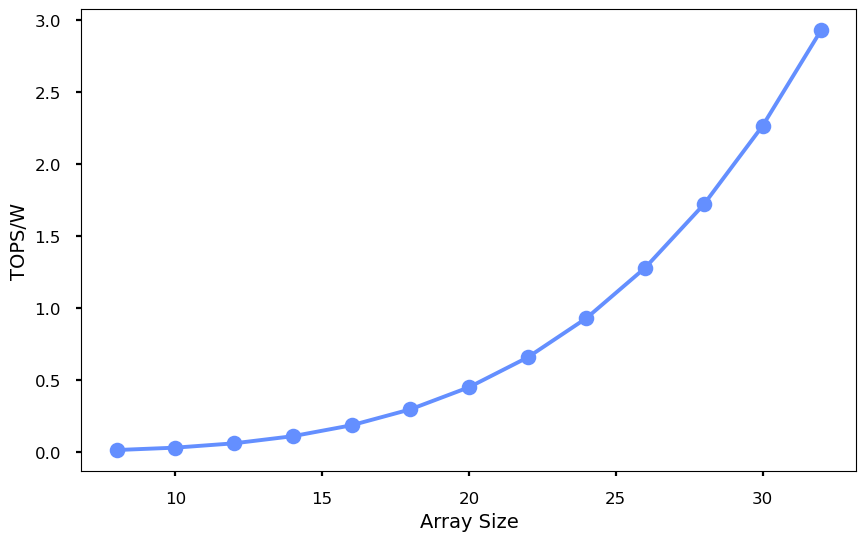

In [295]:
# Plot the data
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.plot(dim_arr[:,0], tops_w_arr, 'o-', c='#648FFF')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel('Array Size', size=14)
ax1.set_ylabel('TOPS/W', size=14)
# ax1.set_title('Scaling with increasing size of array')

# Save the figure
plt.savefig("out/Power/TOPSW Scaling with Array Size.pdf", transparent=True)
plt.savefig("out/Power/TOPSW Scaling with Array Size.png", dpi=800, transparent=True)

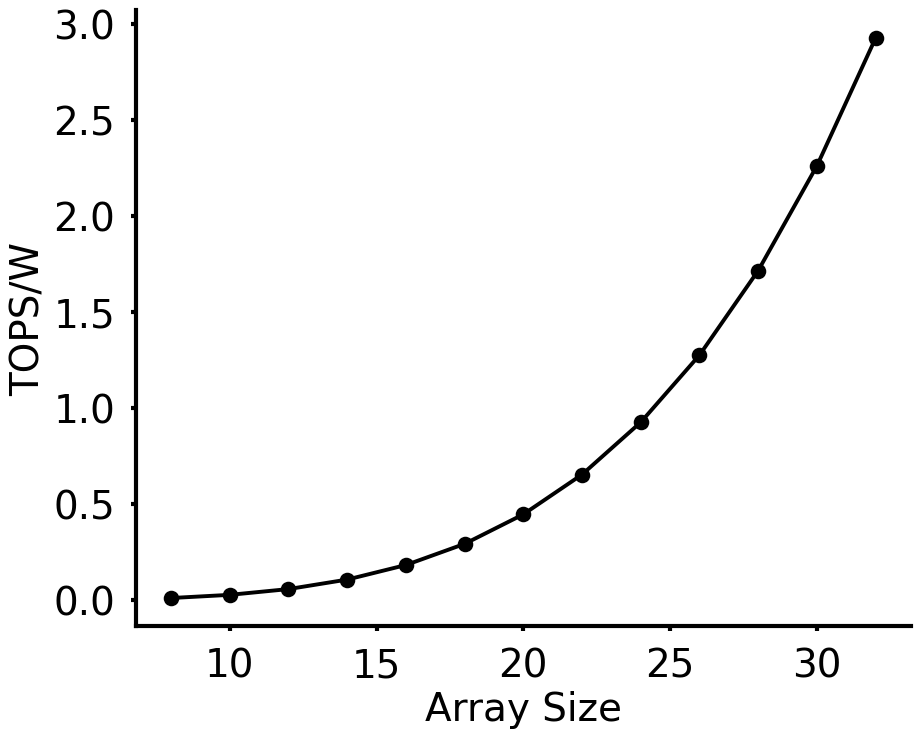

In [250]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(dim_arr[:,0], tops_w_arr, 'o-', c='k')
# plt.title('Scaling with increasing size of array')
# ax.legend(fontsize=28)

ax.set_ylabel('TOPS/W', fontsize=28)
ax.set_xlabel('Array Size', fontsize=28)

ax.tick_params(axis='both', labelsize=28, width=3)

# Increase the line thickness of the bounding box
for spine in ax.spines.values():
    spine.set_linewidth(3)

# Remove splines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# Add splines on left and bottom sides
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('out/Power/power-size-scaling (0,8).pdf', bbox_inches='tight')
plt.show()


### Scaling with frequency
There are commercially available 1GSPS ADC chip such as [ADC08D1000](https://www.ti.com/lit/ds/symlink/adc08d1000.pdf?ts=1701709167422&ref_url=https%253A%252F%252Fwww.google.com%252F) from Texas instruments. However the limitation in that is power consumption and complexity of supporting electronics. Additionally the limitation with data-transfer rates gets into play here. The data-rate required to process  single channel at 1GSPS is 8Gbps. When we scale this out to array sizes such as $32 \times 32$, we get to a data-rate of  8.192 Tbps and the cards with fastest transfer rates is 512 Gbps with PCI Express v5 x16 ([source](https://www.electronicshub.org/how-many-pcie-lanes-do-i-have/)). So we need 16 PCI Express v5 ×16 lanes to process this amount of data which leads to the main bottleneck. For demonstration, we consider datarates that are feasible with a single PCIe v5 ×16 connector which would be 62.5MSPS

In [316]:
# Creating an array of frequencies
freq_arr = np.linspace(0, 20e6, 15)

# Setting other parameters
dim_freq_arr_1 = [32, 32]
dim_freq_arr_2 = [16, 16]
dim_freq_arr_3 = [8, 8]

# Calculating
# Calculating the number of operations at a time step
op_arr_1 = (dim_freq_arr_1[0]**2 * 0.5 * dim_freq_arr_1[1]**2) + (dim_freq_arr_1[0] * 0.5 * dim_freq_arr_1[1])
op_arr_2 = (dim_freq_arr_2[0]**2 * 0.5 * dim_freq_arr_2[1]**2) + (dim_freq_arr_2[0] * 0.5 * dim_freq_arr_2[1])
op_arr_3 = (dim_freq_arr_3[0]**2 * 0.5 * dim_freq_arr_3[1]**2) + (dim_freq_arr_3[0] * 0.5 * dim_freq_arr_3[1])

# Calculating the number of operations per second
ops_arr_1 = op_arr_1 * freq_arr
ops_arr_2 = op_arr_2 * freq_arr
ops_arr_3 = op_arr_3 * freq_arr

# Calculating the power consumed per operation
tops_w_arr_1 = ops_arr_1/(power_consumed * num_channels * 10**12)
tops_w_arr_2 = ops_arr_2/(power_consumed * num_channels * 10**12)
tops_w_arr_3 = ops_arr_3/(power_consumed * num_channels * 10**12)

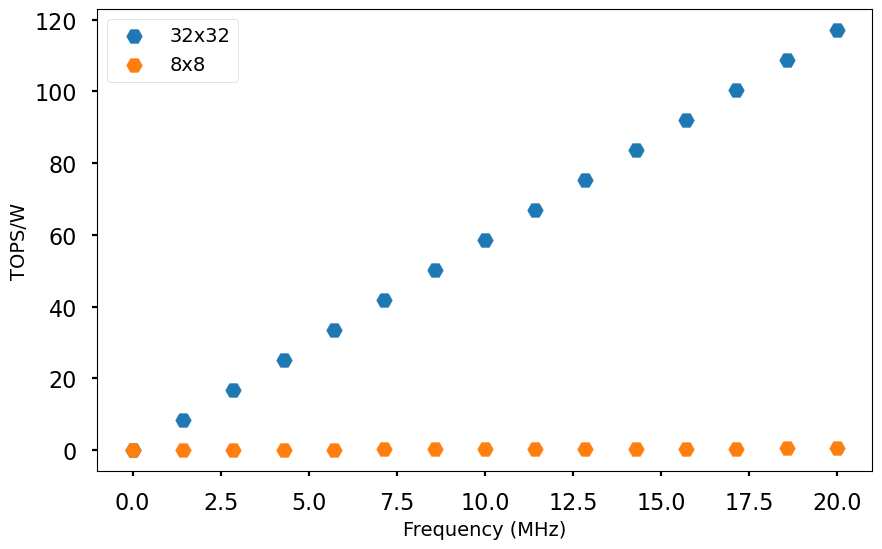

In [321]:
# Plot the data
fig,ax = plt.subplots(figsize=(10, 6))
ax.scatter(freq_arr/1e6, tops_w_arr_1, marker = 'H', label='32x32')
ax.scatter(freq_arr/1e6, tops_w_arr_3, marker = 'H', label='8x8')
ax.set_xlabel('Frequency (MHz)', size=14)
ax.set_ylabel('TOPS/W', size=14) 
# ax.set_title('Scaling with increasing frequency')
ax.legend(fontsize=14)

# Save the figure
plt.savefig("out/Power/TOPSW Scaling with Frequency.pdf", transparent=True)
plt.savefig("out/Power/TOPSW Scaling with Frequency.png", dpi=800, transparent=True)